# Coherency and fooof

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal

## Load Litvak Voxels

In [3]:
#################
# read the data #
#################
f_on_data = '../../data/raw/rest/subj1/on/subj1_on_R7.mat'
f_off_data = '../../data/raw/rest/subj1/off/subj1_off_R7.mat'

on_data = scipy.io.loadmat(f_on_data)['data'][0,0][1][0,0]
on_labels = [i[0][0] for i in scipy.io.loadmat(f_on_data)['data'][0,0][0]]
on_t = scipy.io.loadmat(f_on_data)['data'][0,0][2][0,0][0]

off_data = scipy.io.loadmat(f_off_data)['data'][0,0][1][0,0]
off_labels = [i[0][0] for i in scipy.io.loadmat(f_off_data)['data'][0,0][0]]
off_t = scipy.io.loadmat(f_off_data)['data'][0,0][2][0,0][0]

if np.allclose(np.diff(on_t), np.diff(on_t)[0]):
    on_d = np.diff(on_t)[0]
    on_s_rate = 1./on_d
else:
    raise ValueError('Signal must be evenly sampled')

if np.allclose(np.diff(off_t), np.diff(off_t)[0]):
    off_d = np.diff(off_t)[0]
    off_s_rate = 1./off_d
else:
    raise ValueError('Signal must be evenly sampled')

if not on_labels == off_labels:
    raise ValueError('channel labels must be equal during on and off')

In [4]:
del on_labels[-1] # last entry is event marker

### Calc power spectra using Welch's method

In [5]:
n_elecs = 9
on_f, on_csd = scipy.signal.welch(on_data[0], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
on_csds = np.zeros([n_elecs, on_csd.shape[0]])
off_csds = np.zeros([n_elecs, on_csd.shape[0]])

for i in range(n_elecs):
    on_f, on_csds[i] = scipy.signal.welch(on_data[i], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
    off_f, off_csds[i] = scipy.signal.welch(off_data[i], fs=on_s_rate, nperseg=2*on_s_rate, average="median")
 

In [6]:
from fooof import FOOOF

In [12]:
on_f[:]

array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 1.1990e+03, 1.1995e+03,
       1.2000e+03])

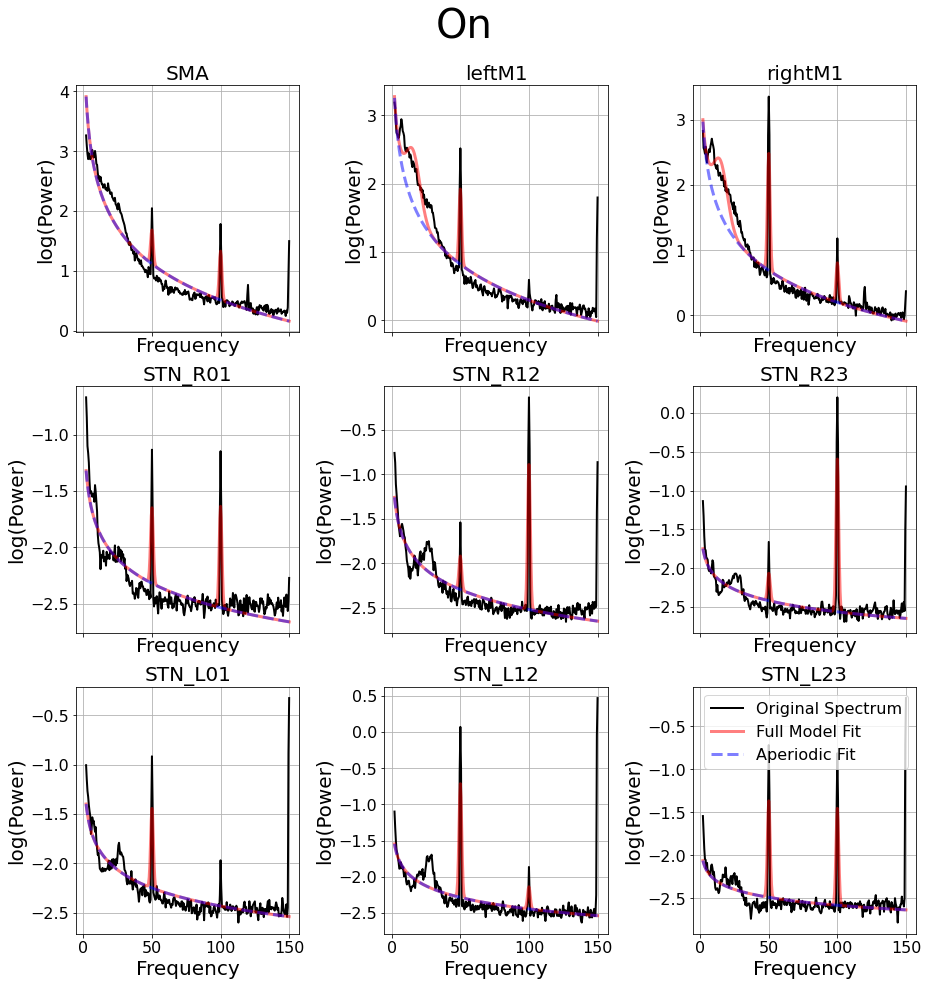

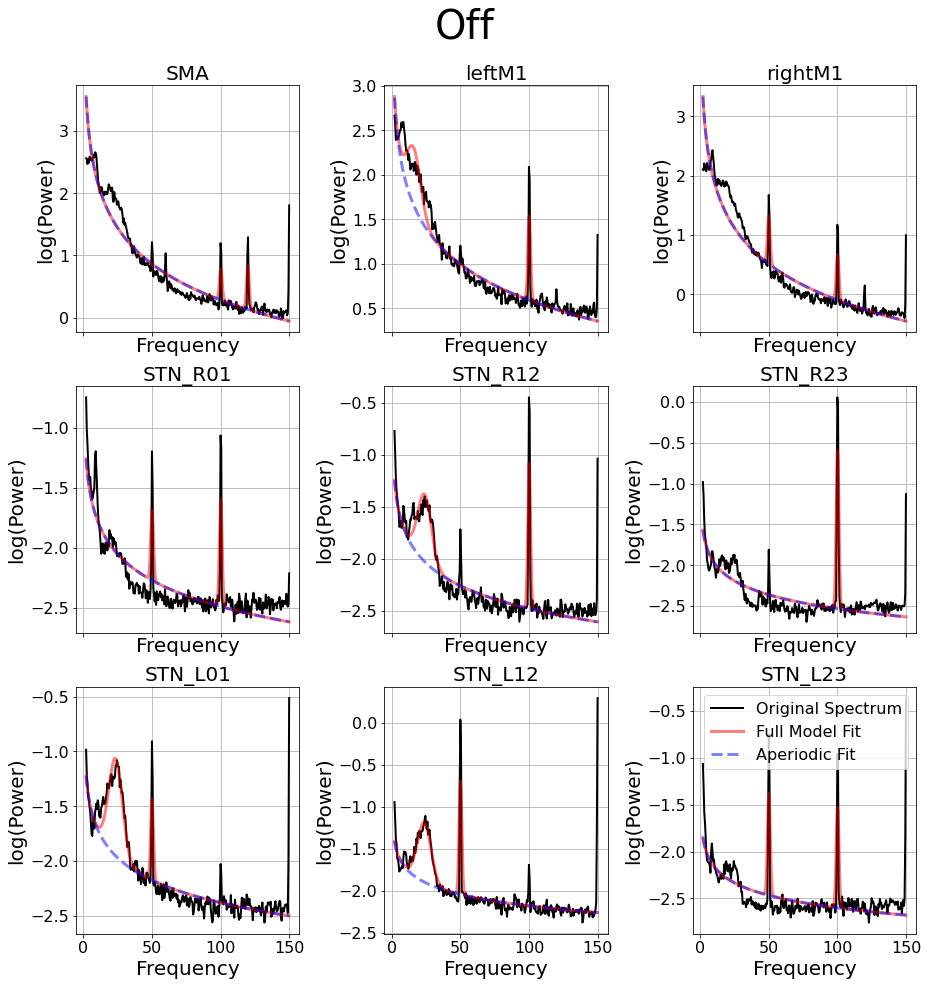

In [7]:
freq_range = [2, 140]

fm = FOOOF(peak_width_limits=(2, 10), max_n_peaks=3, min_peak_height=0, peak_threshold=2, aperiodic_mode="fixed", verbose=True)

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(on_f, np.abs(on_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(on_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("On", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_on.pdf', bbox_inches="tight")

fig, ax = plt.subplots(3, 3, figsize=(13, 13), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm.fit(off_f, np.abs(off_csds[i, :]), freq_range)
    fm.plot(ax=ax[i])
   # fm.print_results()
    ax[i].set_title(off_labels[i], fontsize=20)
    if i < 8:
        ax[i].get_legend().remove()

plt.suptitle("Off", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_off.pdf', bbox_inches="tight")

# Filter the AC artefact

In [10]:
sample_r = 2400

In [8]:
# Create filter using 
FIR = scipy.signal.firwin(240, fs=sample_r)


on_csds_filt = scipy.signal.firwin() on_csds

array([[4.38000937e+01, 2.75804128e+02, 2.91738177e+03, ...,
        6.50957996e-07, 7.18046135e-07, 2.46871497e-07],
       [3.02571141e+01, 2.74675864e+02, 1.91918455e+03, ...,
        1.18646104e-06, 1.44778185e-06, 4.76182393e-07],
       [1.03475287e+01, 7.18214240e+01, 6.30748101e+02, ...,
        3.57516858e-07, 3.67353054e-07, 1.66273527e-07],
       ...,
       [2.56643175e-03, 9.76335523e-03, 1.12688560e-01, ...,
        3.53835008e-11, 3.63245138e-11, 1.18472687e-11],
       [2.79946571e-03, 7.79189961e-03, 1.30225090e-01, ...,
        5.60157004e-11, 4.38499598e-11, 1.43790758e-11],
       [6.18370111e-04, 3.00367985e-03, 3.40493885e-02, ...,
        4.90249201e-11, 5.08516603e-11, 2.18114039e-11]])

# Calculate exponent

Range: 20-100Hz
Use "knee" mode

I should apply notch filters at n*50Hz

In [93]:
fm_knee = FOOOF(peak_width_limits=(0.2, 12.0), min_peak_height=0, peak_threshold=3, aperiodic_mode='knee', max_n_peaks=3)

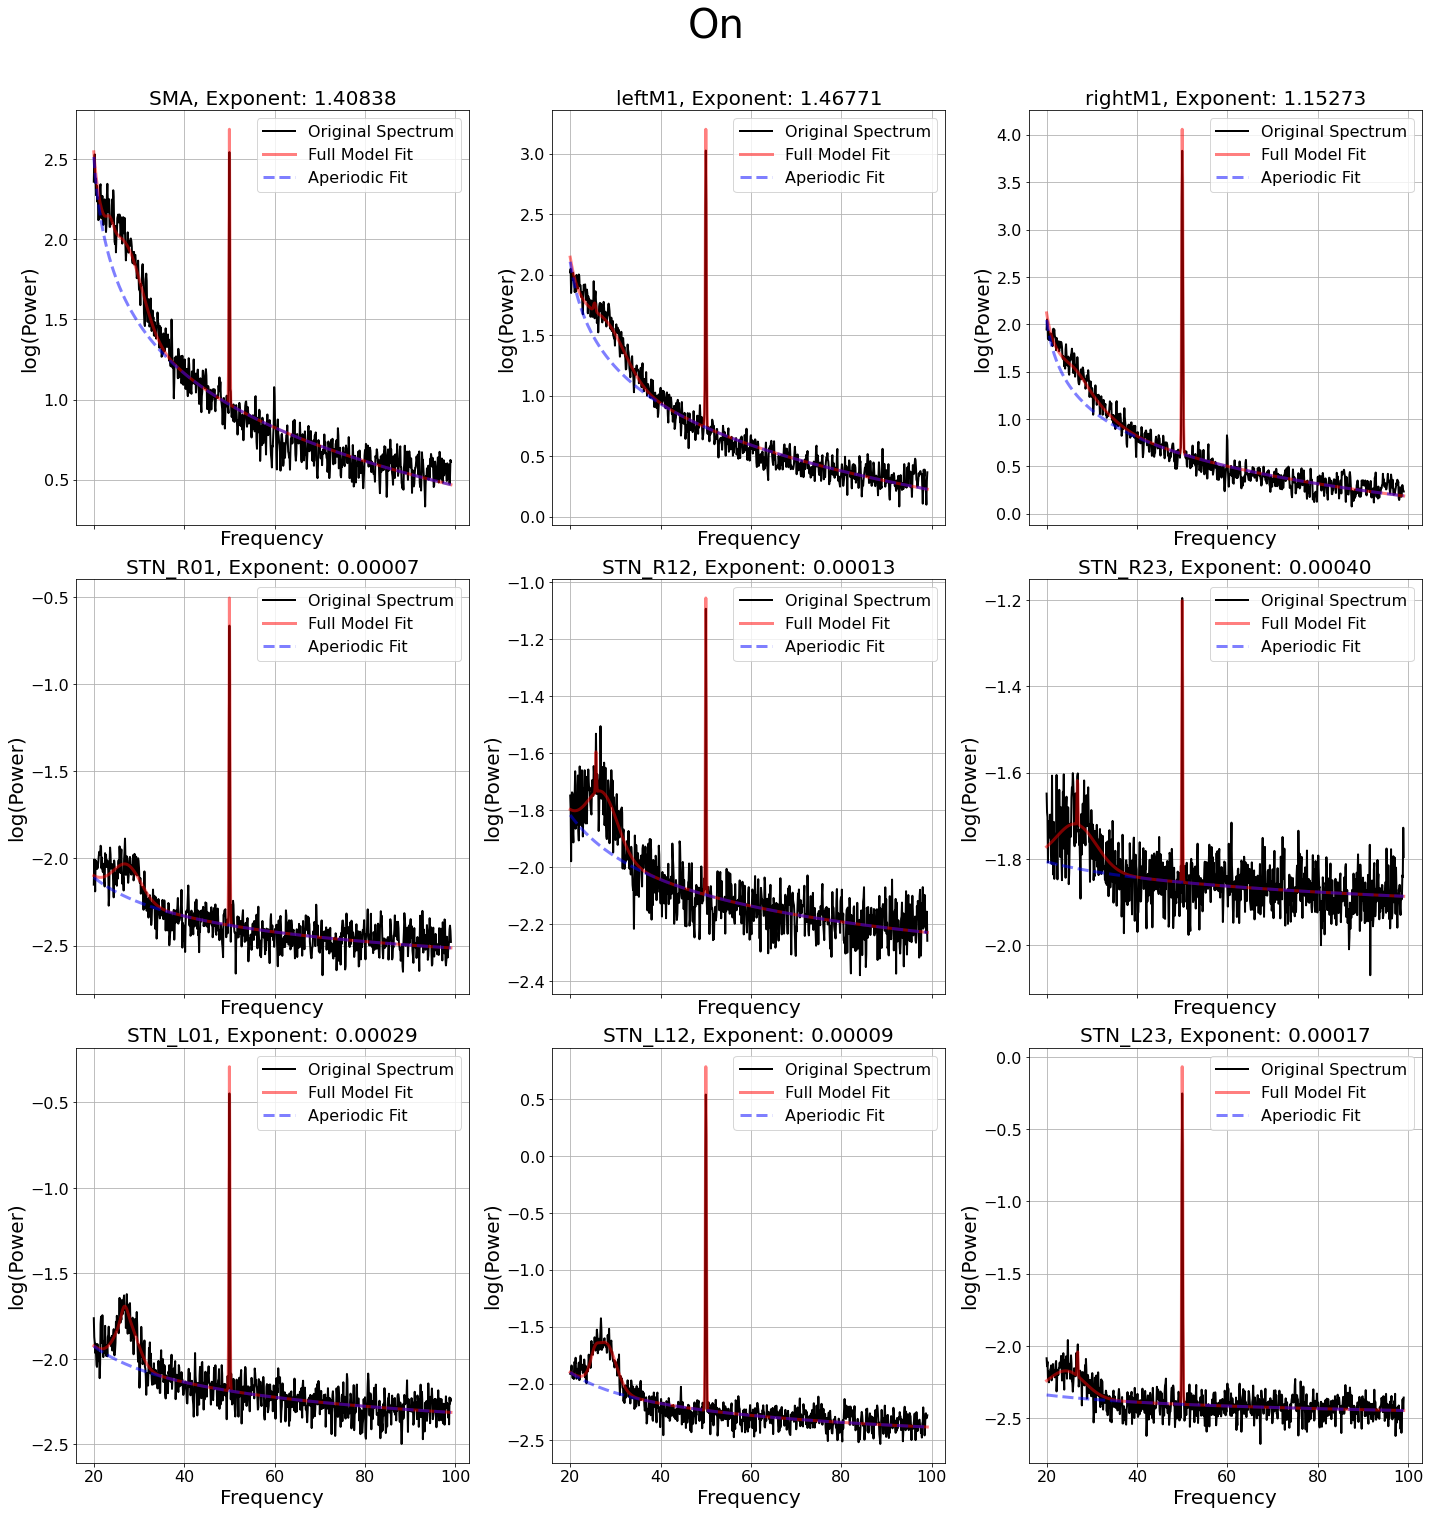

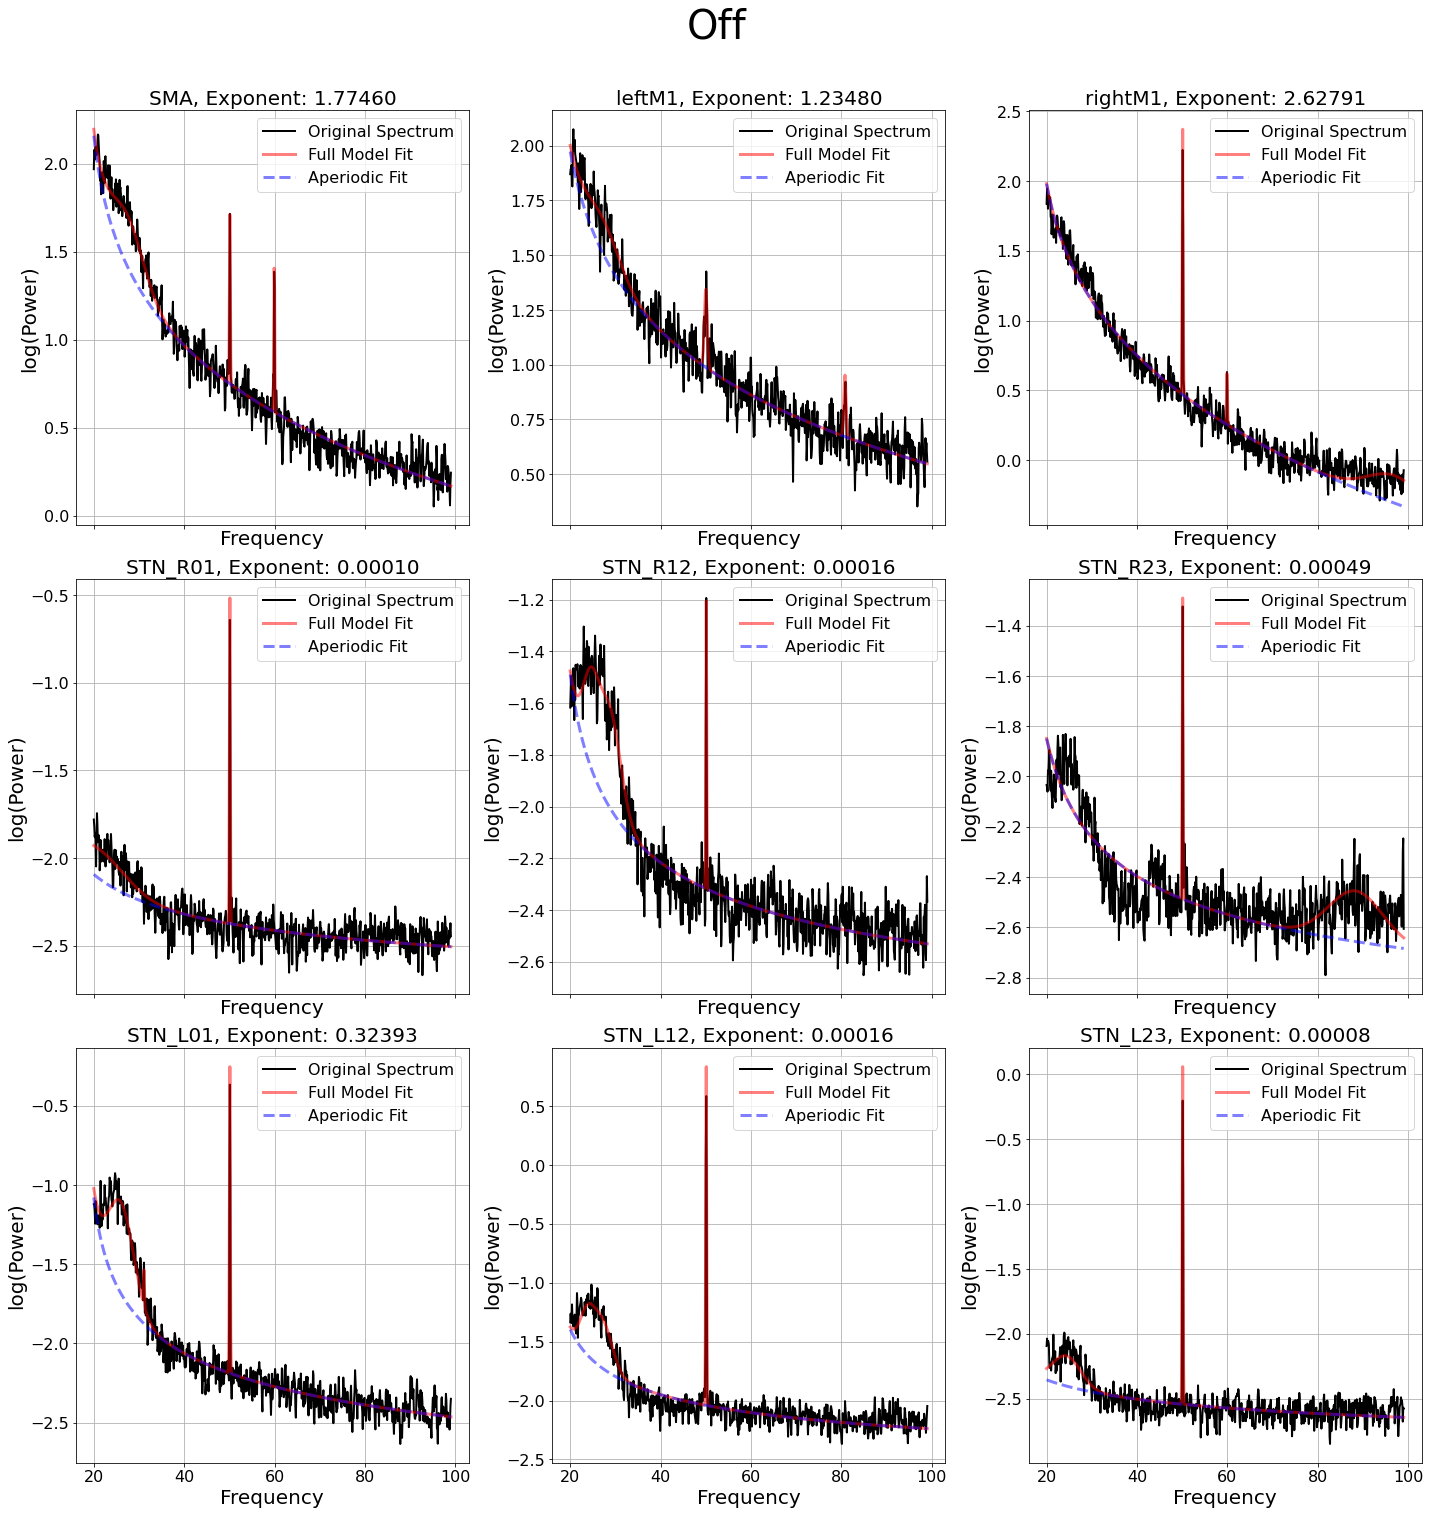

In [95]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm_knee.fit(on_f, np.abs(on_csds[i]), [20, 99])
    exp = fm_knee.get_params('aperiodic_params', 'exponent')
    fm_knee.plot(ax=ax[i])
    ax[i].set_title(f"{on_labels[i]}, Exponent: {exp:.5f}", fontsize=20)

plt.suptitle("On", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_on.pdf', bbox_inches="tight")
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm_knee.fit(off_f, np.abs(off_csds[i]), [20, 99])
    exp = fm_knee.get_params('aperiodic_params', 'exponent')
    fm_knee.plot(ax=ax[i])
    ax[i].set_title(f"{on_labels[i]}, Exponent: {exp:.5f}", fontsize=20)

plt.suptitle("Off", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()

# Make fooof group

In [128]:
from fooof import FOOOFGroup
fg=FOOOFGroup()
fg_knee=FOOOFGroup(peak_width_limits=(0.2, 12.0), min_peak_height=0, peak_threshold=3, aperiodic_mode='knee', max_n_peaks=3)

Running FOOOFGroup across 9 power spectra.
Mean Exponent Cortex: 2.28 +/- 0.09, Mean Exponent STN: 0.47 +/- 0.20


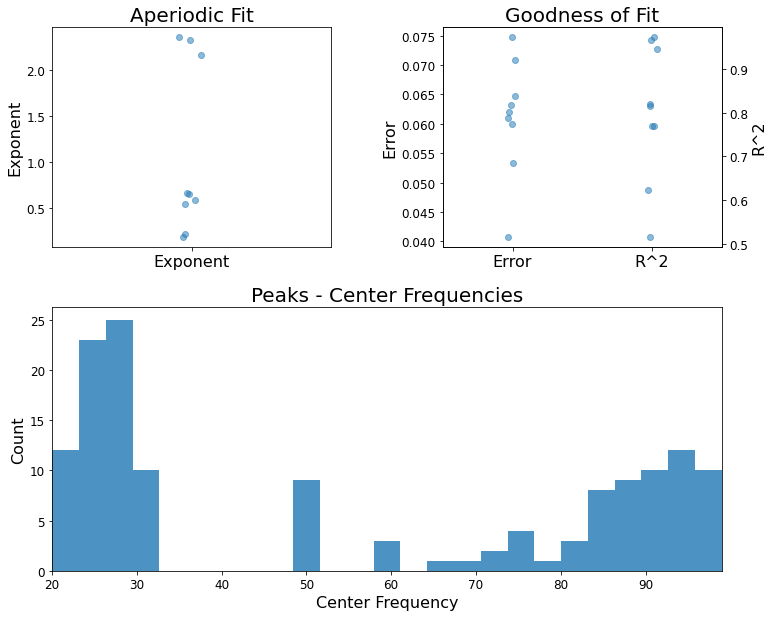

In [129]:
fg.fit(on_f, on_csds, [20, 99])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent Cortex: {np.mean(exp[:3]):.2f} +/- {np.std(exp[:3]):.2f}, Mean Exponent STN: {np.mean(exp[3:]):.2f} +/- {np.std(exp[3:]):.2f}")
fg.plot()
#print(exp[:3])
#print(exp[3:])

Running FOOOFGroup across 9 power spectra.
Mean Exponent Cortex: 2.38 +/- 0.38, Mean Exponent STN: 0.79 +/- 0.36


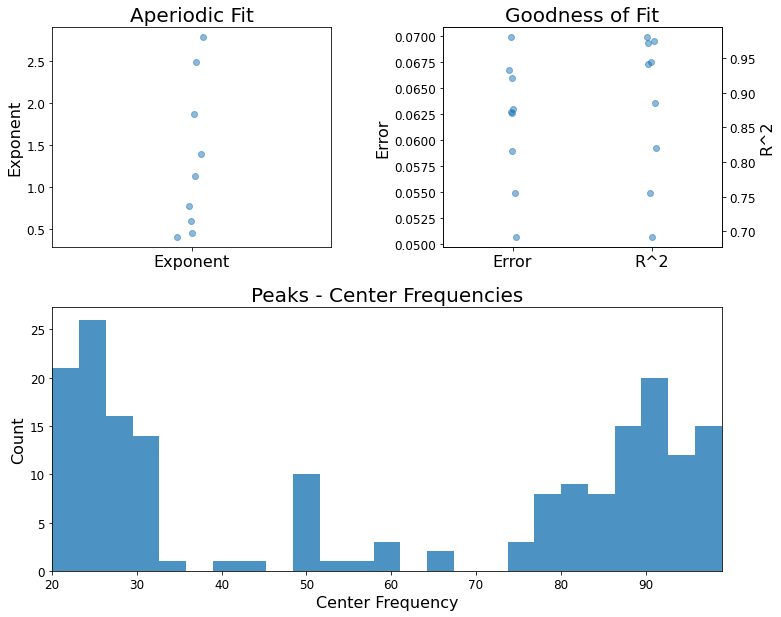

In [131]:
fg.fit(off_f, off_csds, [20, 99])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent Cortex: {np.mean(exp[:3]):.2f} +/- {np.std(exp[:3]):.2f}, Mean Exponent STN: {np.mean(exp[3:]):.2f} +/- {np.std(exp[3:]):.2f}")
fg.plot()

### numbers per segment: 1 times sample rate. Reason: Teilantrag mentions 1s segments, and fooof doc says: "Input power spectra should be smooth, as overly noisy power spectra may lead to bad fits"

In [136]:
n_elecs = 9
on_f, on_csd = scipy.signal.welch(on_data[0], fs=on_s_rate, nperseg=1*on_s_rate)
on_csds = np.zeros([n_elecs, on_csd.shape[0]])
off_csds = np.zeros([n_elecs, on_csd.shape[0]])

for i in range(n_elecs):
    on_f, on_csds[i] = scipy.signal.welch(on_data[i], fs=on_s_rate, nperseg=1*on_s_rate)
    off_f, off_csds[i] = scipy.signal.welch(off_data[i], fs=on_s_rate, nperseg=1*on_s_rate)
 

In [160]:
fm_knee = FOOOF(peak_width_limits=(2, 12), min_peak_height=0, peak_threshold=2, aperiodic_mode='knee')#, max_n_peaks=inf)

In [170]:
np.mean([7.5,13,12,7,12])

10.3

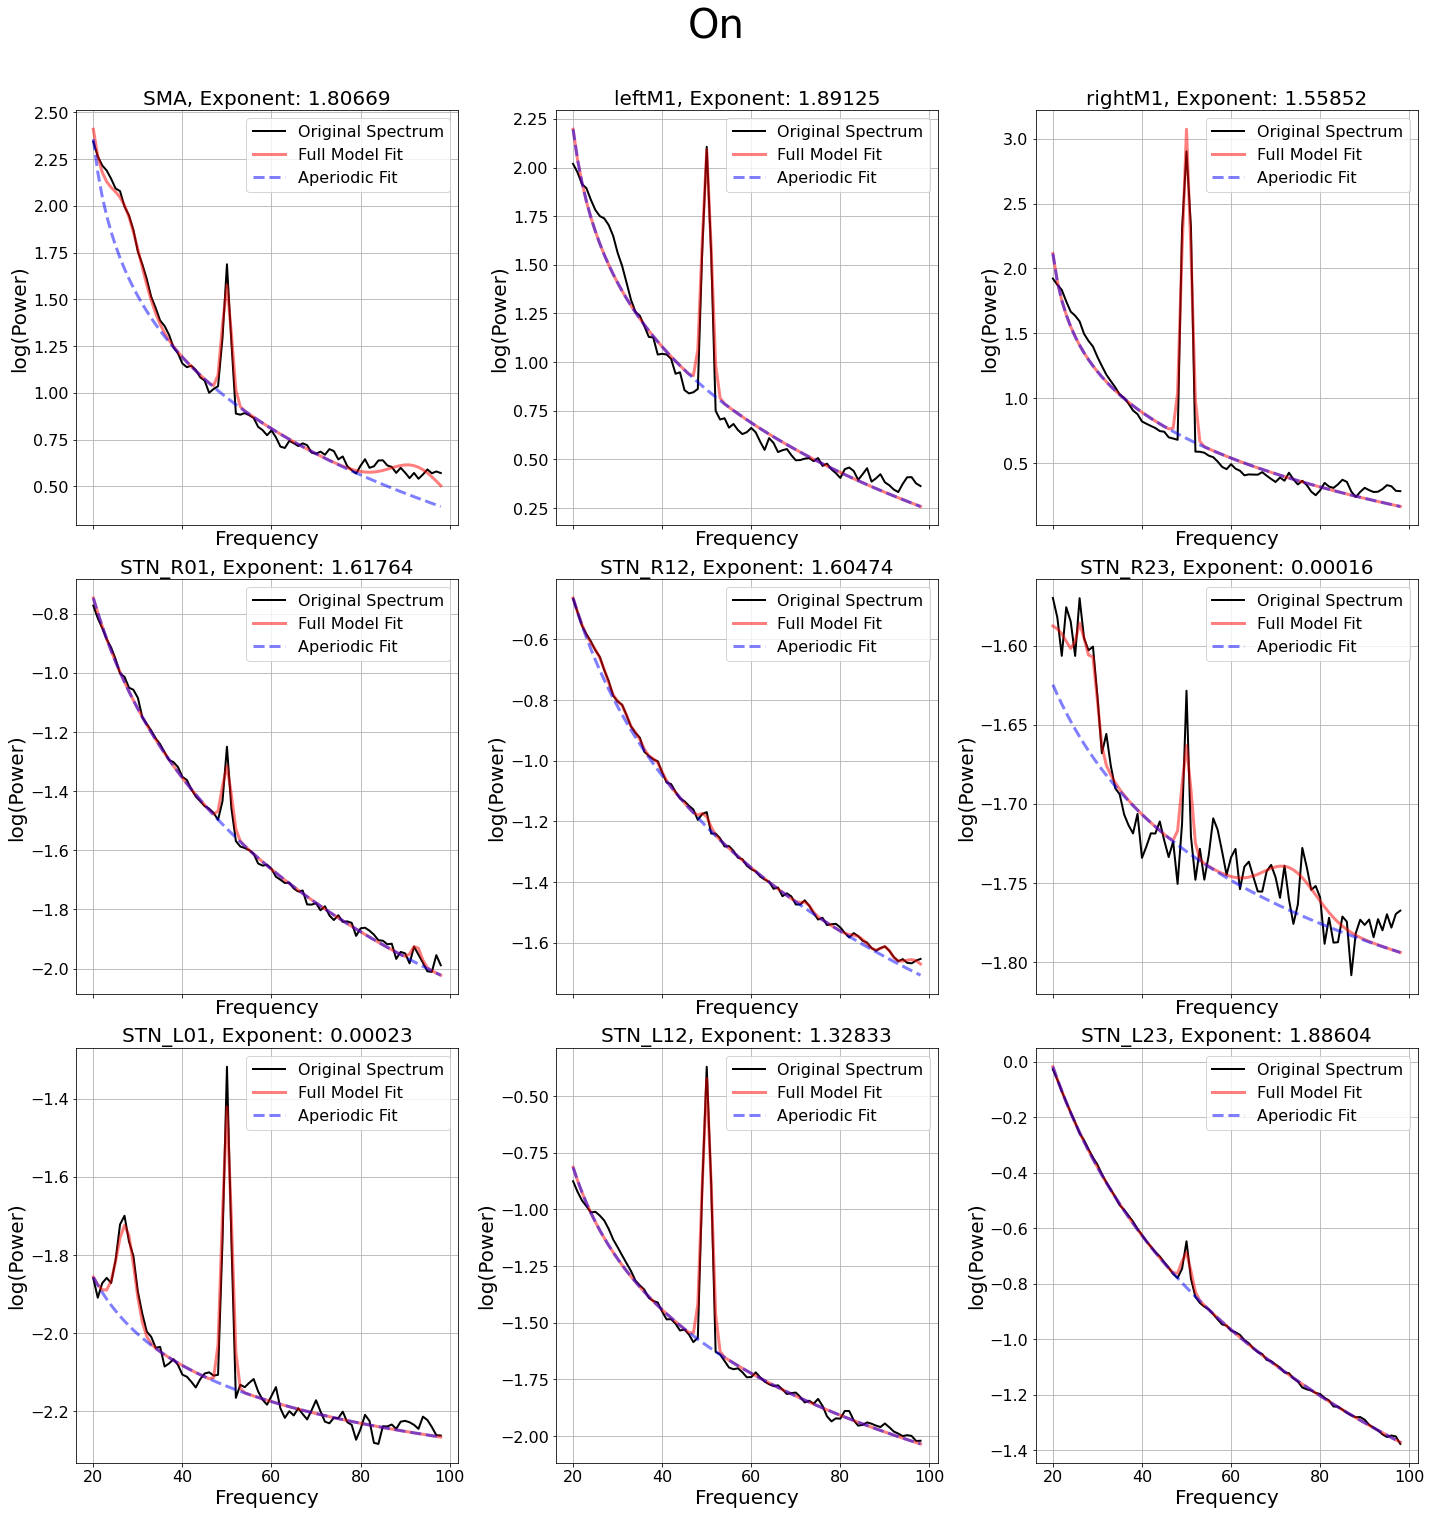

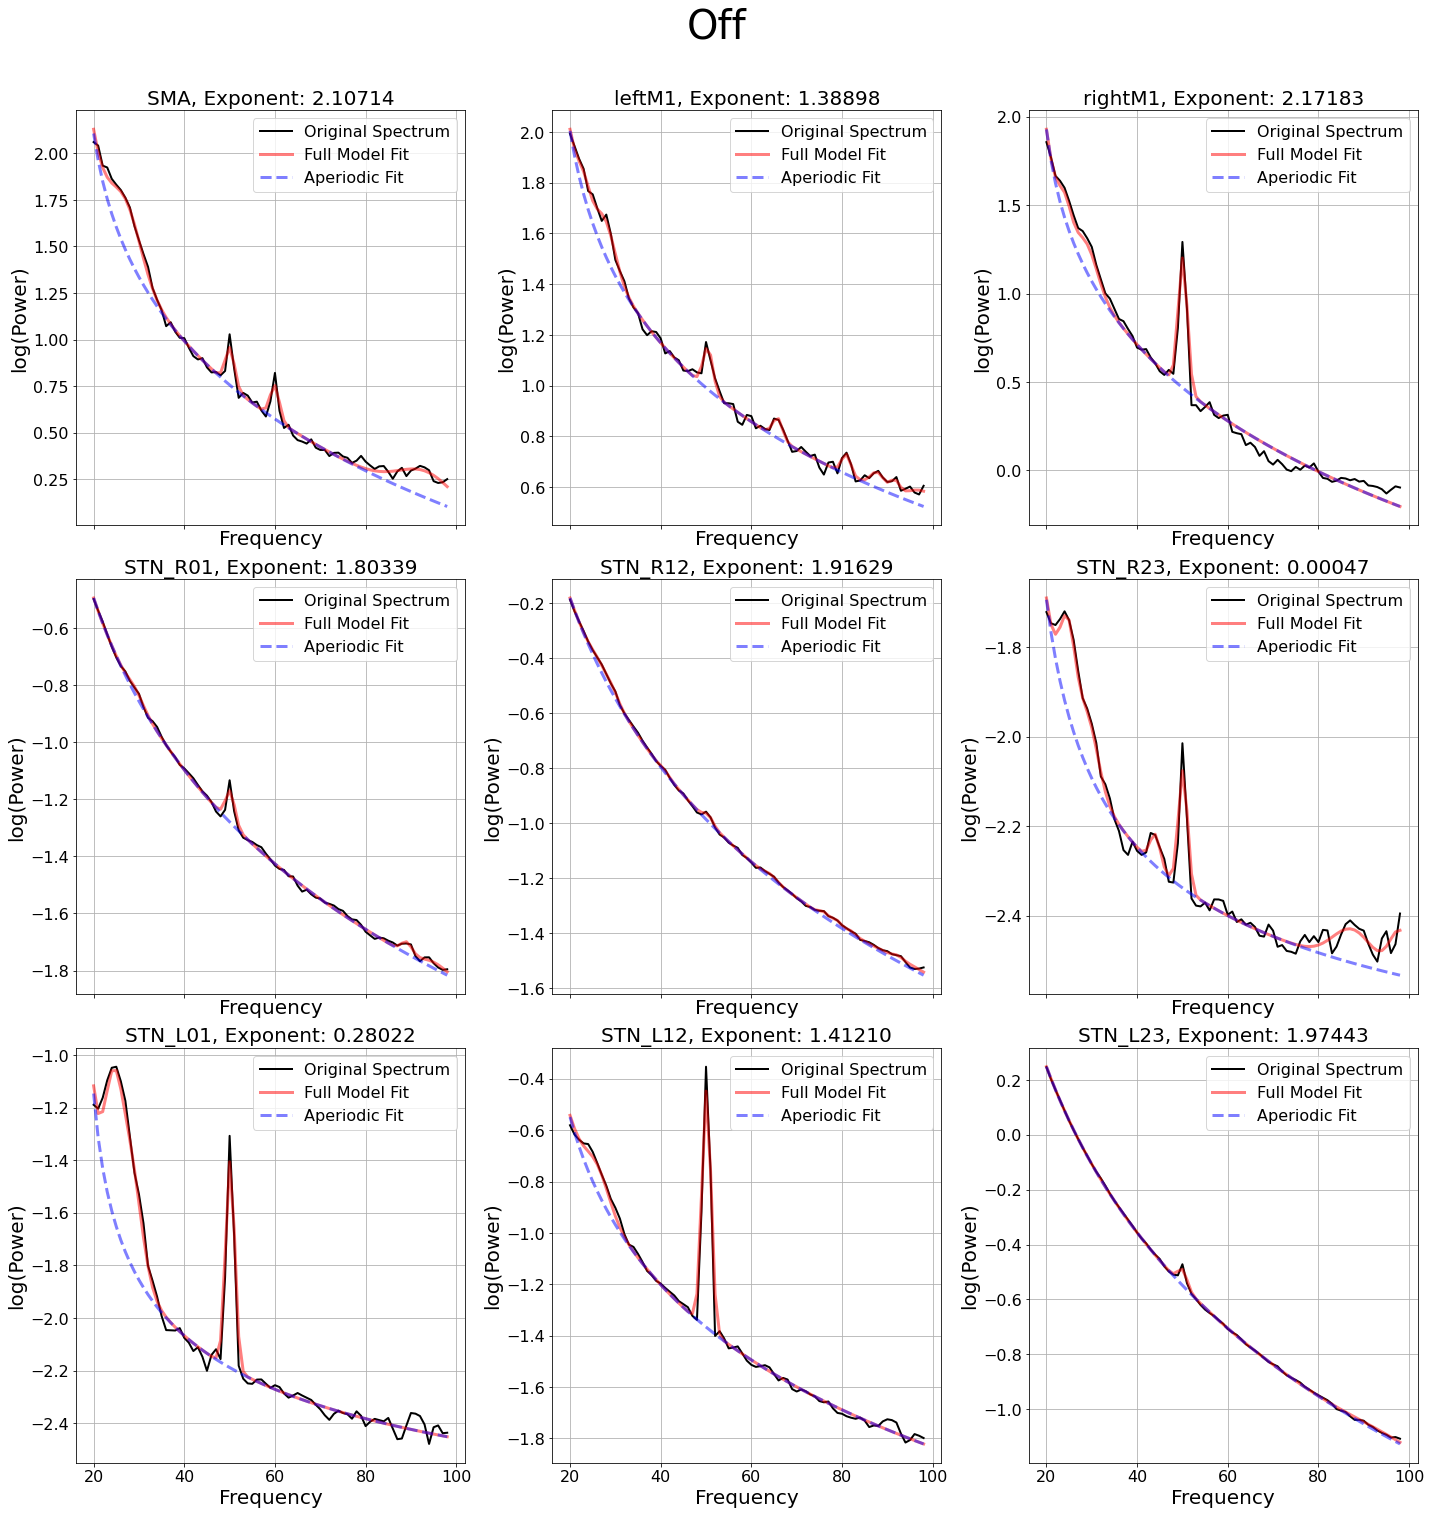

In [165]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm_knee.fit(on_f, np.abs(on_csds[i]), [20, 98]) # exclude 100 Hz peak
    exp = fm_knee.get_params('aperiodic_params', 'exponent')
    fm_knee.plot(ax=ax[i])
    ax[i].set_title(f"{on_labels[i]}, Exponent: {exp:.5f}", fontsize=20)

plt.suptitle("On", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_spectra_on.pdf', bbox_inches="tight")
fig, ax = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=False)
ax = ax.flatten()
for i in range(9):
    fm_knee.fit(off_f, np.abs(off_csds[i]), [20, 98])
    exp = fm_knee.get_params('aperiodic_params', 'exponent')
    fm_knee.plot(ax=ax[i])
    ax[i].set_title(f"{on_labels[i]}, Exponent: {exp:.5f}", fontsize=20)

plt.suptitle("Off", fontsize=40, position=(0.5, 1.05))
plt.tight_layout()
#plt.savefig('../../plots/fooof_with_50Hz_artefact.pdf')

Running FOOOFGroup across 3 power spectra.
Mean Exponent Cortex On: 1.75 +/- 0.14
Running FOOOFGroup across 3 power spectra.
Mean Exponent Cortex Off: 1.89 +/- 0.35
Running FOOOFGroup across 6 power spectra.
Mean Exponent STN On: 1.07 +/- 0.78
Running FOOOFGroup across 6 power spectra.
Mean Exponent STN Off: 1.23 +/- 0.80


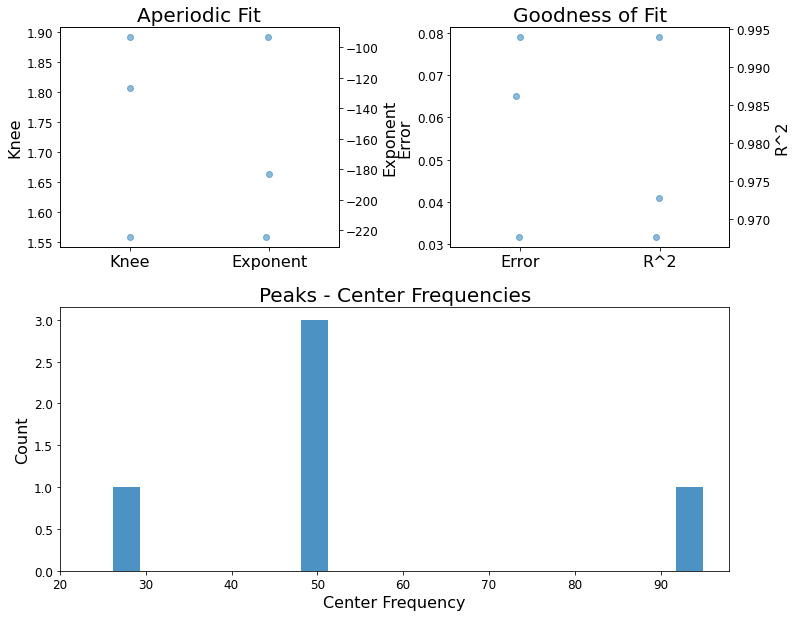

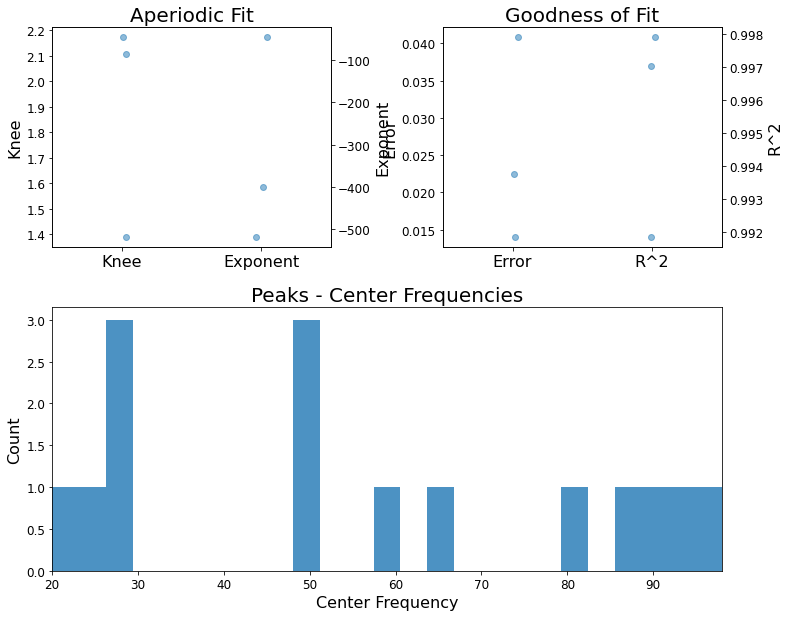

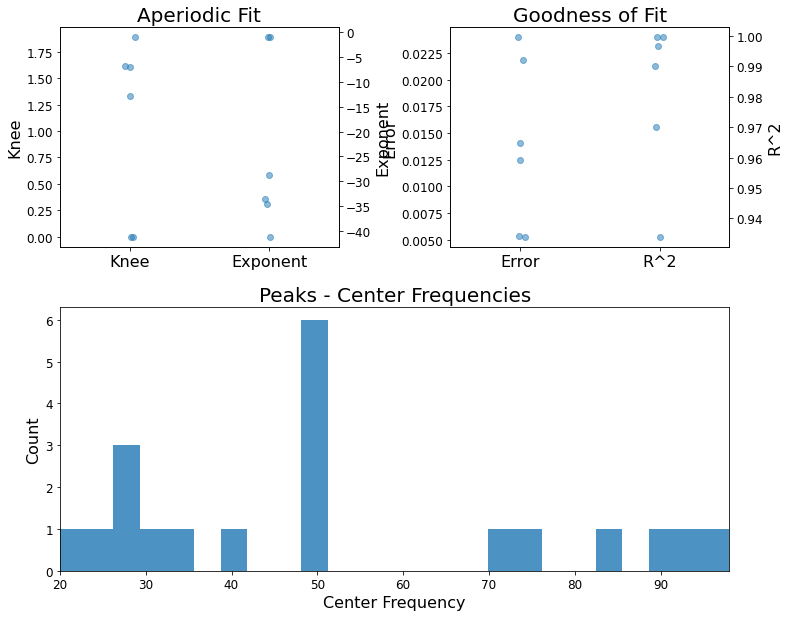

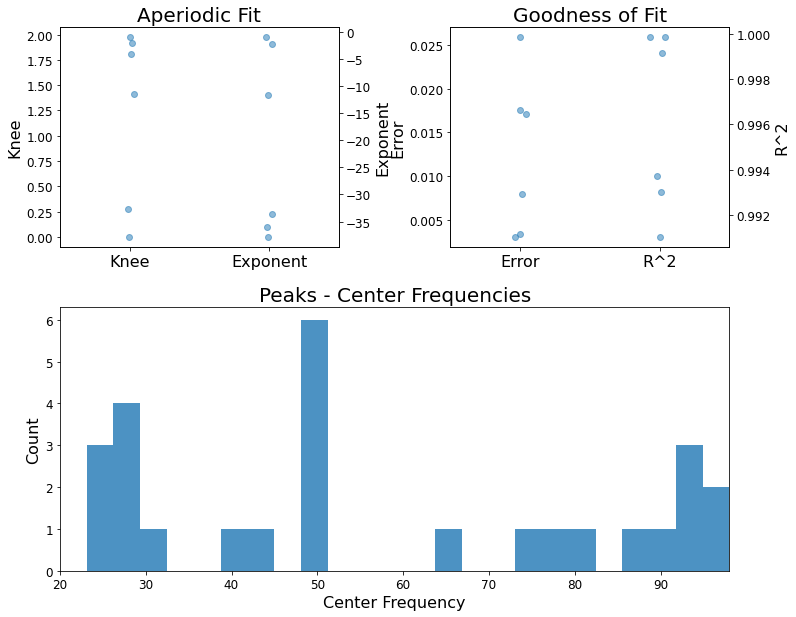

In [164]:
from fooof import FOOOFGroup
fg=FOOOFGroup(peak_width_limits=(2, 12), min_peak_height=0, peak_threshold=2, aperiodic_mode='knee')
#fg_knee=FOOOFGroup(peak_width_limits=(0.2, 12.0), min_peak_height=0, peak_threshold=3, aperiodic_mode='knee', max_n_peaks=3)
fg.fit(on_f, on_csds[:3], [20, 98])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent Cortex On: {np.mean(exp[:3]):.2f} +/- {np.std(exp[:3]):.2f}")
fg.plot()


fg.fit(off_f, off_csds[:3], [20, 98])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent Cortex Off: {np.mean(exp):.2f} +/- {np.std(exp):.2f}")
fg.plot()


fg.fit(on_f, on_csds[3:], [20, 98])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent STN On: {np.mean(exp):.2f} +/- {np.std(exp):.2f}")
fg.plot()


fg.fit(off_f, off_csds[3:], [20, 98])
exp = fg.get_params('aperiodic_params', 'exponent')
print(f"Mean Exponent STN Off: {np.mean(exp):.2f} +/- {np.std(exp):.2f}")
fg.plot()